# CNN - MM21B051 - Preethi
The pdf version of this notebook has all outputs and graphs, kindly refer to it
We begin with loading the dataset, I have downloaded it locally
We unpickle the dataset as mentioned in the official website and convert into a torch tensor, so that we can calculate the gradients and back-propagate in the later stages.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

# load 1 training batch alone
train_data, train_labels = [], []

for i in range(1, 2):  # data_batch_1 to data_batch_5
    batch = unpickle(f'C:/Users/Preethi/Downloads/EE5178-Assgn1/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

# Convert to NumPy arrays
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
train_labels = np.array(train_labels)

# Load test data
test_batch = unpickle('C:/Users/Preethi/Downloads/EE5178-Assgn1/cifar-10-python/cifar-10-batches-py/test_batch')
test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
test_labels = np.array(test_batch[b'labels'])

# Convert to PyTorch tensors
train_data = torch.tensor(train_data).float()
train_labels = torch.tensor(train_labels).long()
test_data = torch.tensor(test_data).float()
test_labels = torch.tensor(test_labels).long()

# Create DataLoader
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_labels), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_labels), batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We next train the model with VGG11 architechtiure on one of the training datasets (10000 images), with varying learning rates and batch sizes. 
learning_rates = [0.01, 0.001, 0.1]
batch_sizes = [32, 64, 128]
We have patience value as 2, to speed up the training process and limit it to 10 epochs at max. The patience is incremented in the validation loss increases for two consecutive iterations, indicating that further iterations aren't useful.


Training with Learning Rate=0.01
Epoch 1: Train Loss=2.3035, Val Loss=2.3030
Epoch 2: Train Loss=2.3028, Val Loss=2.3028
Epoch 3: Train Loss=2.3025, Val Loss=2.3032
Early stopping triggered!

Training with Learning Rate=0.001
Epoch 1: Train Loss=2.3044, Val Loss=2.3036
Epoch 2: Train Loss=2.3037, Val Loss=2.3032
Epoch 3: Train Loss=2.3031, Val Loss=2.3030
Early stopping triggered!

Training with Learning Rate=0.1
Epoch 1: Train Loss=2.3070, Val Loss=2.3045
Epoch 2: Train Loss=2.3072, Val Loss=2.3068
Epoch 3: Train Loss=2.3064, Val Loss=2.3061
Early stopping triggered!

Training with Batch Size=32
Epoch 1: Train Loss=2.3041, Val Loss=2.3031
Epoch 2: Train Loss=2.3030, Val Loss=2.3028
Epoch 3: Train Loss=2.3027, Val Loss=2.3028
Early stopping triggered!

Training with Batch Size=64
Epoch 1: Train Loss=2.3038, Val Loss=2.3035
Epoch 2: Train Loss=2.3031, Val Loss=2.3032
Epoch 3: Train Loss=2.3029, Val Loss=2.3031
Early stopping triggered!

Training with Batch Size=128
Epoch 1: Train Loss=

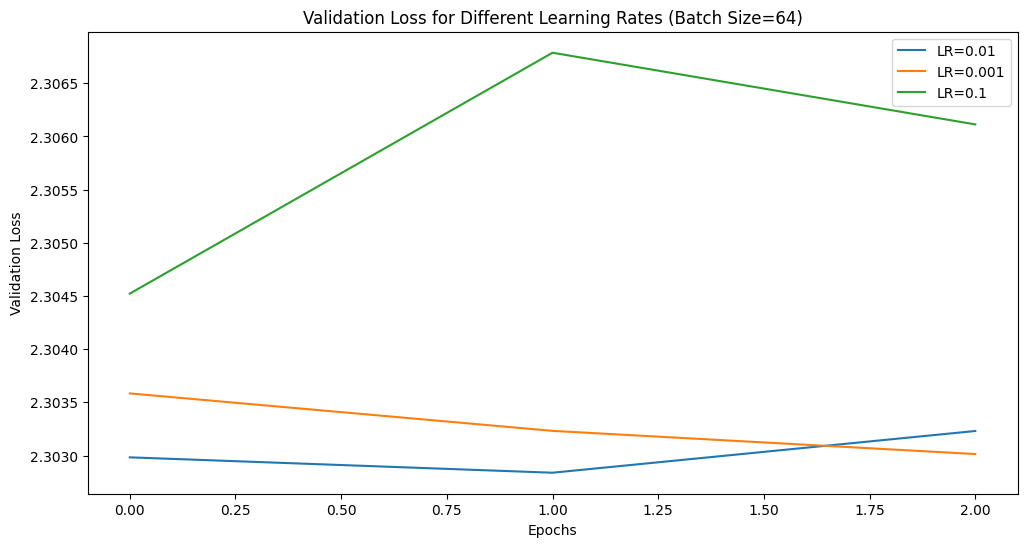

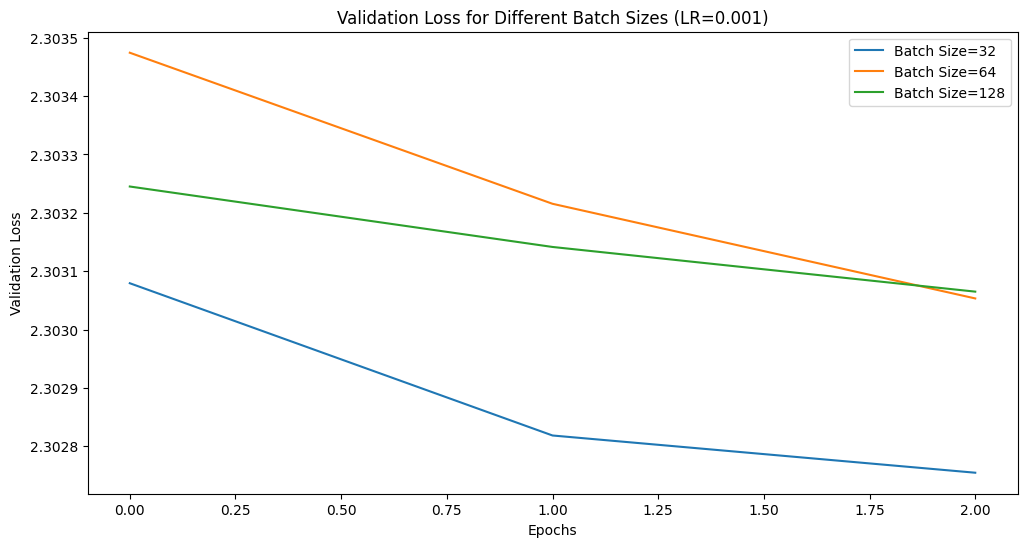

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define VGG11 Model
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define Training Function with Early Stopping
def train_model(lr=None, batch_size=None, num_epochs=10, fixed_lr=0.001, fixed_batch_size=64, patience=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use either a fixed batch size or a fixed learning rate
    batch_size = batch_size if batch_size else fixed_batch_size
    lr = lr if lr else fixed_lr

    # Load Data
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_data, train_labels),
        batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_data, test_labels),
        batch_size=batch_size, shuffle=False
    )

    # Initialize Model, Loss, and Optimizer
    model = VGG11().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        # Early Stopping with Dynamic Patience
        if val_loss < best_val_loss:
            if best_val_loss - val_loss > 0.001:
                patience_counter = 0  # Reset patience if loss decreases significantly
            else:
                patience_counter += 1  # Increase patience if improvement is very small
            best_val_loss = val_loss
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


    return train_losses, val_losses

# Hyperparameters to test
learning_rates = [0.01, 0.001, 0.1]
batch_sizes = [32, 64, 128]

# Store results separately
lr_results = {}
batch_results = {}

# Train for different learning rates (fixed batch size = 64)
for lr in learning_rates:
    print(f"\nTraining with Learning Rate={lr}")
    train_losses, val_losses = train_model(lr=lr)
    lr_results[lr] = (train_losses, val_losses)

# Train for different batch sizes (fixed learning rate = 0.001)
for batch_size in batch_sizes:
    print(f"\nTraining with Batch Size={batch_size}")
    train_losses, val_losses = train_model(batch_size=batch_size)
    batch_results[batch_size] = (train_losses, val_losses)

# Plot Learning Rate Results
plt.figure(figsize=(12, 6))
for lr, (train_losses, val_losses) in lr_results.items():
    plt.plot(val_losses, label=f"LR={lr}")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for Different Learning Rates (Batch Size=64)")
plt.legend()
plt.show()

# Plot Batch Size Results
plt.figure(figsize=(12, 6))
for batch_size, (train_losses, val_losses) in batch_results.items():
    plt.plot(val_losses, label=f"Batch Size={batch_size}")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for Different Batch Sizes (LR=0.001)")
plt.legend()
plt.show()


From the graphs, we notice that of the learning rates and batch sizes explored, 0.001 lr and bacth size of 32 have the bets results. This indicates that a lower learning rate and lower batch size lead to higher accuracy and lower losses. [We could try lr of 0.0001 and lower batch sizes, however the time taken would be hihger to train]

Epoch 1/10: 100%|██████████| 282/282 [01:42<00:00,  2.76it/s]


Epoch 1/10, Train Loss: 2.0762, Train Acc: 17.00%, Val Loss: 2.1816, Val Acc: 16.20%


Epoch 2/10: 100%|██████████| 282/282 [01:40<00:00,  2.81it/s]


Epoch 2/10, Train Loss: 1.9449, Train Acc: 18.49%, Val Loss: 1.8780, Val Acc: 19.80%


Epoch 3/10: 100%|██████████| 282/282 [01:46<00:00,  2.64it/s]


Epoch 3/10, Train Loss: 1.9084, Train Acc: 19.41%, Val Loss: 1.8211, Val Acc: 22.50%


Epoch 4/10: 100%|██████████| 282/282 [01:45<00:00,  2.66it/s]


Epoch 4/10, Train Loss: 1.8771, Train Acc: 20.98%, Val Loss: 1.8296, Val Acc: 23.80%


Epoch 5/10: 100%|██████████| 282/282 [01:46<00:00,  2.65it/s]


Epoch 5/10, Train Loss: 1.7787, Train Acc: 26.73%, Val Loss: 1.6605, Val Acc: 33.00%


Epoch 6/10: 100%|██████████| 282/282 [01:45<00:00,  2.66it/s]


Epoch 6/10, Train Loss: 1.6940, Train Acc: 30.90%, Val Loss: 1.6266, Val Acc: 35.70%


Epoch 7/10: 100%|██████████| 282/282 [01:45<00:00,  2.67it/s]


Epoch 7/10, Train Loss: 1.5938, Train Acc: 36.08%, Val Loss: 1.6653, Val Acc: 32.70%


Epoch 8/10: 100%|██████████| 282/282 [01:53<00:00,  2.48it/s]


Epoch 8/10, Train Loss: 1.5475, Train Acc: 38.50%, Val Loss: 1.5592, Val Acc: 41.80%


Epoch 9/10: 100%|██████████| 282/282 [02:00<00:00,  2.34it/s]


Epoch 9/10, Train Loss: 1.4741, Train Acc: 41.59%, Val Loss: 1.3932, Val Acc: 43.50%


Epoch 10/10: 100%|██████████| 282/282 [01:46<00:00,  2.64it/s]


Epoch 10/10, Train Loss: 1.4069, Train Acc: 43.30%, Val Loss: 1.4667, Val Acc: 41.70%


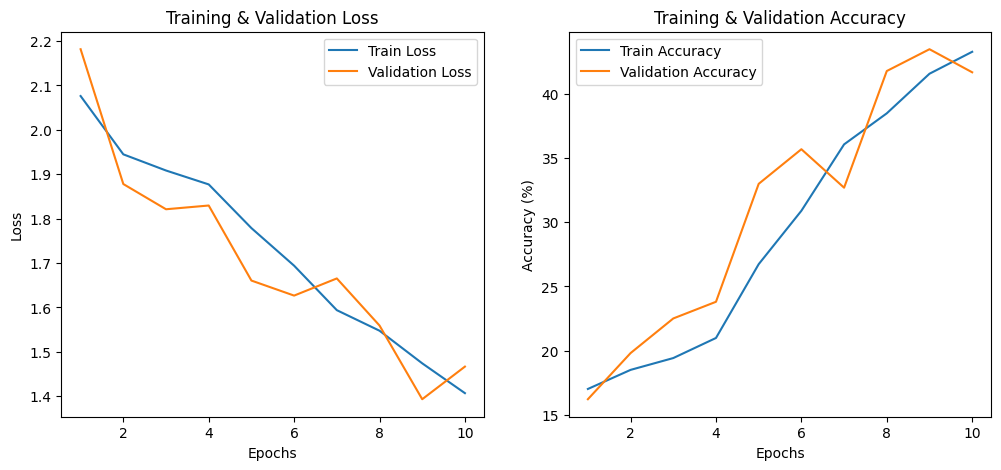

Test Accuracy: 40.87%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# import cv2
import random
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm

# Define VGG11 Model
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Add this
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Add this
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Add this
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Add this
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),  # Add this
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),  # Add this
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),  # Add this
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),  # Add this
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Function to Train Model
def train_model(model, train_loader, val_loader, lr=0.001, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    return model

# Function to Evaluate Model on Validation/Test Set
def evaluate_model(model, loader, criterion=None):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()

    avg_loss = running_loss / len(loader) if criterion else None
    return (avg_loss, 100 * correct / total) if criterion else 100 * correct / total

# Function to Plot Training and Validation Loss/Accuracy
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()

# Function to Test Model on Test Set
def test_model(model, test_loader):
    test_acc = evaluate_model(model, test_loader)
    print(f"Test Accuracy: {test_acc:.2f}%")

# Load Local CIFAR-10 Data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

# Load training batches
train_data, train_labels = [], []
for i in range(1, 2):
    batch = unpickle(f'C:/Users/Preethi/Downloads/EE5178-Assgn1/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
train_labels = np.array(train_labels)

# Load test data
test_batch = unpickle('C:/Users/Preethi/Downloads/EE5178-Assgn1/cifar-10-python/cifar-10-batches-py/test_batch')
test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
test_labels = np.array(test_batch[b'labels'])

# Convert to PyTorch tensors
train_data, train_labels = torch.tensor(train_data), torch.tensor(train_labels)
test_data, test_labels = torch.tensor(test_data), torch.tensor(test_labels)

# Train-Validation Split
dataset = TensorDataset(train_data, train_labels)
train_size = int(0.9 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32)

# Train & Evaluate
model = train_model(VGG11(), train_loader, val_loader)
test_model(model, test_loader)


We get an accuracy of 40+%, on the test data set upon training with the given parameters. We next try to visualize the ouputs predicted of 5 random images from each class.

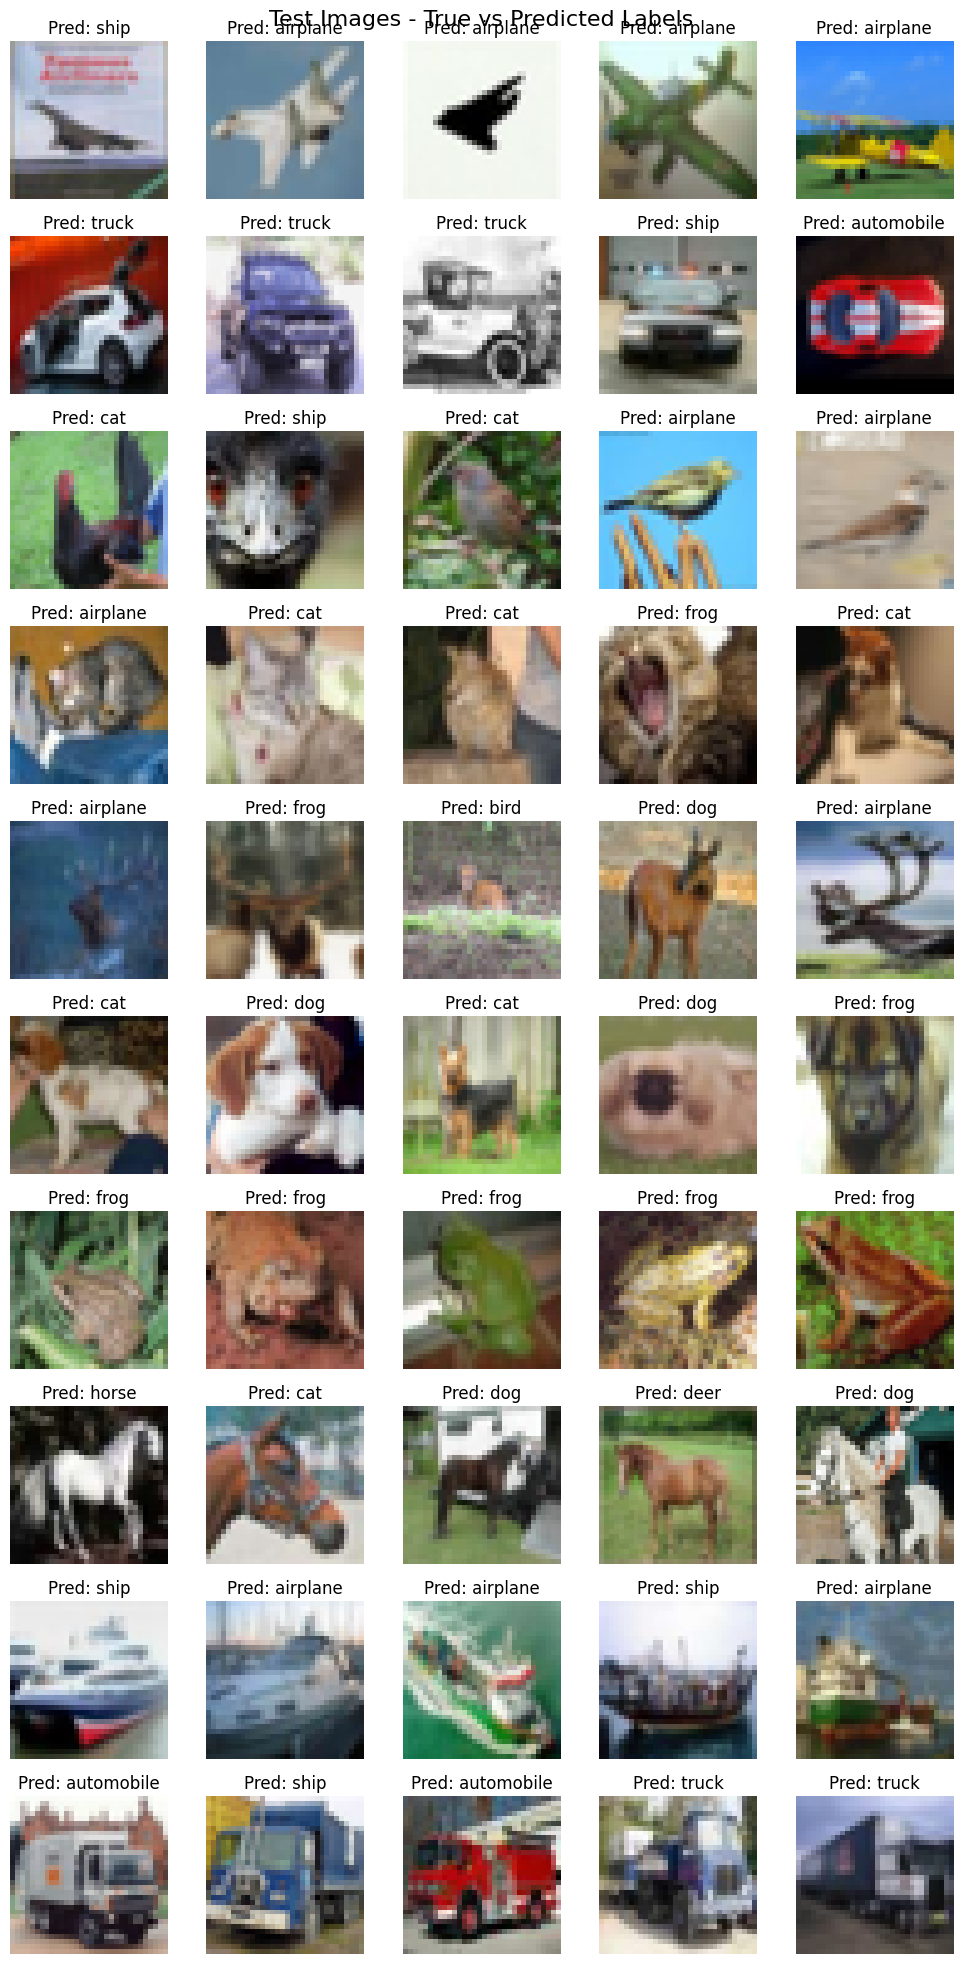

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Class Labels for CIFAR-10
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

# Function to Display Five Test Images per Class
def display_test_results(model, test_loader, class_labels):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    images_per_class = {label: [] for label in range(len(class_labels))}

    # Collect five images per class
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for img, true_label, pred_label in zip(images, labels, predicted):
                if len(images_per_class[true_label.item()]) < 5:
                    images_per_class[true_label.item()].append((img.cpu(), pred_label.item()))
            
            # Stop if we have 5 images per class
            if all(len(images) >= 5 for images in images_per_class.values()):
                break

    # Plot images
    fig, axes = plt.subplots(len(class_labels), 5, figsize=(10, 20))
    for class_idx, (true_label, img_list) in enumerate(images_per_class.items()):
        for i, (img, pred_label) in enumerate(img_list):
            img = img.permute(1, 2, 0).numpy()  # Convert tensor to image format
            axes[class_idx, i].imshow(img)
            axes[class_idx, i].set_title(f"Pred: {class_labels[pred_label]}")
            axes[class_idx, i].axis("off")

    plt.suptitle("Test Images - True vs Predicted Labels", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
display_test_results(model, test_loader, class_labels)


We test the model on 5 random images downloaded externally from the internet. The images are resized to 32 x 32 pixels to fit the model architectire.

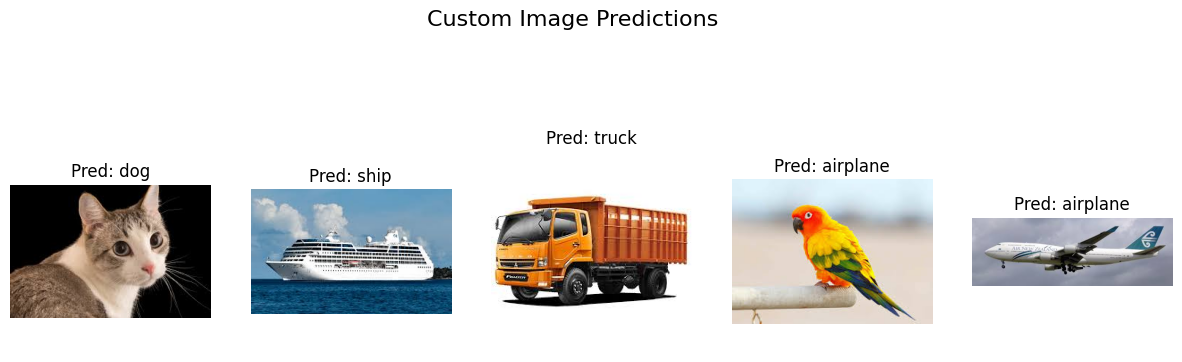

In [22]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class Labels for CIFAR-10
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match CIFAR-10 input size
    transforms.ToTensor()         # Convert image to tensor and normalize to [0,1]
])

# Function to Test on Custom Images without cv2
def test_custom_images(model, image_paths):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

    for idx, image_path in enumerate(image_paths):
        img = Image.open(image_path).convert("RGB")  # Open and convert to RGB
        img_tensor = transform(img).unsqueeze(0).to(device)  # Apply transforms

        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            pred_label = class_labels[predicted.item()]

        axes[idx].imshow(img)
        axes[idx].set_title(f"Pred: {pred_label}", fontsize=12)
        axes[idx].axis("off")

    plt.suptitle("Custom Image Predictions", fontsize=16)
    plt.show()

# Test on 5 Downloaded or Captured Images (Modify Paths Accordingly)
custom_image_paths = [
    "C:/Users/Preethi/Downloads/EE5178-Assgn1/images/image1.jpg",
    "C:/Users/Preethi/Downloads/EE5178-Assgn1/images/image2.jpg",
    "C:/Users/Preethi/Downloads/EE5178-Assgn1/images/image3.jpg",
    "C:/Users/Preethi/Downloads/EE5178-Assgn1/images/image4.jpg",
    "C:/Users/Preethi/Downloads/EE5178-Assgn1/images/image5.jpg"
]

test_custom_images(model, custom_image_paths)